# Installation of required libraries and basic setup

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
import os
import glob
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%cd /content/gdrive/MyDrive/Colab\ Notebooks
!ls



Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks
data  Landslide4sense_TransferLearning.ipynb


# Data Loading & Preprocessing

In [ ]:

def load_dataset(image_paths, mask_paths=None):
    valid_images = []
    valid_masks = [] if mask_paths is not None else None
    corrupted_images_count = 0
    corrupted_masks_count = 0

    for i, img_path in enumerate(image_paths):
        try:
            with h5py.File(img_path, 'r') as hdf:
                data = np.array(hdf.get('img'), dtype=np.float32)
        except Exception as e:
            print(f"Skipping image file {img_path} due to error: {e}")
            corrupted_images_count += 1
            continue

        # Replace NaNs and compute mid values
        data[np.isnan(data)] = 1e-6
        mid_rgb       = data[:, :, 1:4].max() / 2.0
        mid_slope     = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # NDVI calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        ndvi = np.divide(data_nir - data_red, (data_nir + data_red) + 1e-6)

        # Build the 6‐channel image
        img_array = np.empty((128, 128, 6), dtype=np.float32)
        img_array[:, :, 0] = 1.0 - (data[:, :, 3] / (mid_rgb + 1e-6))     # R
        img_array[:, :, 1] = 1.0 - (data[:, :, 2] / (mid_rgb + 1e-6))     # G
        img_array[:, :, 2] = 1.0 - (data[:, :, 1] / (mid_rgb + 1e-6))     # B
        img_array[:, :, 3] = ndvi
        img_array[:, :, 4] = 1.0 - (data[:, :, 12] / (mid_slope + 1e-6))  # Slope
        img_array[:, :, 5] = 1.0 - (data[:, :, 13] / (mid_elevation + 1e-6))  # Elevation

        valid_images.append(img_array)

        if mask_paths is not None:
            try:
                with h5py.File(mask_paths[i], 'r') as hdf_mask:
                    mask_data = np.array(hdf_mask.get('mask'), dtype=np.float32)
                valid_masks.append(mask_data)
            except Exception as e:
                print(f"Skipping mask file {mask_paths[i]} due to error: {e}")
                corrupted_masks_count += 1
                continue

    X = np.array(valid_images)
    Y = np.array(valid_masks) if mask_paths is not None else None

    # Print summary
    print("Dataset loading completed:")
    print(f"Total image files provided: {len(image_paths)}")
    print(f"Valid images loaded: {X.shape[0]}")
    print(f"Corrupted/failed image files: {corrupted_images_count}")

    if mask_paths is not None:
        print(f"Total mask files provided: {len(mask_paths)}")
        print(f"Valid masks loaded: {Y.shape[0]}")
        print(f"Corrupted/failed mask files: {corrupted_masks_count}")

        # Count landslide‐positive vs. negative
        positive_count = sum(np.sum(mask) > 0 for mask in Y)
        negative_count = Y.shape[0] - positive_count
        print(f"Landslide positive images (mask > 0): {positive_count}")
        print(f"Non‐landslide images (mask sum == 0): {negative_count}")

    return X, Y


# Preparing Training and Validation

In [ ]:
import glob, os
import matplotlib.pyplot as plt

os.chdir('/content/gdrive/MyDrive/Colab Notebooks/data')

TRAIN_PATH = sorted(glob.glob("/content/gdrive/MyDrive/Colab Notebooks/data/TrainData/img/*.h5"))[:2500]
TRAIN_MASK = sorted(glob.glob("/content/gdrive/MyDrive/Colab Notebooks/data/TrainData/mask/*.h5"))[:2500]

# Loading training set...
TRAIN_XX, TRAIN_YY = load_dataset(TRAIN_PATH, TRAIN_MASK)

print("Train data shape:", TRAIN_XX.shape, TRAIN_YY.shape)
if TRAIN_XX.size > 0 and TRAIN_YY.size > 0:
    print("Train stats:", TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())
else:
    print("No data loaded. Check file paths and dataset.")

# Train/validation split
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(
    TRAIN_XX, TRAIN_YY, test_size=0.2, shuffle=True
)

del TRAIN_XX, TRAIN_YY  # free memory if desired

# Expand mask dims
y_train = np.expand_dims(y_train, axis=-1)  # (80, 128, 128, 1)
y_valid = np.expand_dims(y_valid, axis=-1)  # (20, 128, 128, 1)




Skipping image file /content/gdrive/MyDrive/Colab Notebooks/data/TrainData/img/image_2789.h5 due to error: Unable to synchronously open file (file signature not found)
Dataset loading completed:
Total image files provided: 2500
Valid images loaded: 2499
Corrupted/failed image files: 1
Total mask files provided: 2500
Valid masks loaded: 2499
Corrupted/failed mask files: 0
Landslide positive images (mask > 0): 1549
Non‐landslide images (mask sum == 0): 950
Train data shape: (2499, 128, 128, 6) (2499, 128, 128)
Train stats: -0.9999999 1.0 0.0 1.0


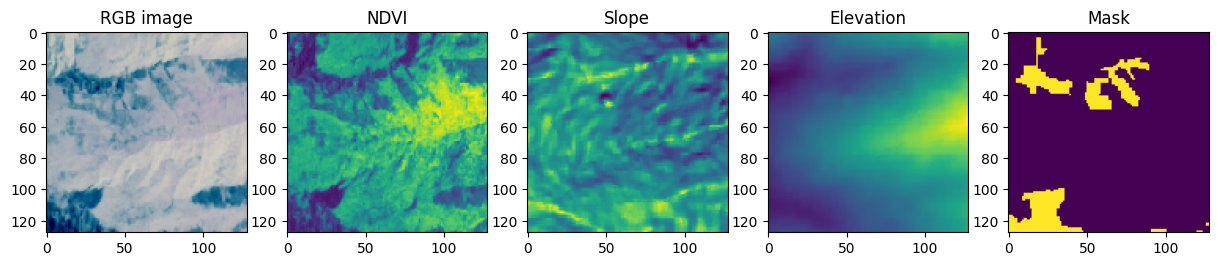

In [ ]:
# Quick visualization
sample_idx = 13
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 10))
ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")

ax1.imshow(x_train[sample_idx, :, :, 0:3])
ax2.imshow(x_train[sample_idx, :, :, 3])
ax3.imshow(x_train[sample_idx, :, :, 4])
ax4.imshow(x_train[sample_idx, :, :, 5])
ax5.imshow(y_train[sample_idx, :, :, 0])
plt.show()

In [ ]:
import tensorflow as tf

# Example: random horizontal & vertical flips
@tf.function
def random_flip(image, mask):
    # Flip left-right
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    # Flip up-down
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    return image, mask

# Create tf.data Datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(random_flip, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(16).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
valid_ds = valid_ds.batch(16).prefetch(tf.data.AUTOTUNE)


In [ ]:
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    # BinaryCrossentropy expects y_pred to be probabilities if from a sigmoid layer
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dc = dice_loss(y_true, y_pred)
    return bce + dc

def _unify_dims(y_true, y_pred):
    if y_true.shape.ndims == 3:
        y_true = tf.expand_dims(y_true, axis=-1)
    return y_true, y_pred

def recall_m(y_true, y_pred):
    y_true, y_pred = _unify_dims(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    y_true, y_pred = _unify_dims(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    y_true, y_pred = _unify_dims(y_true, y_pred)
    prec = precision_m(y_true, y_pred)
    rec = recall_m(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + K.epsilon())


## Building and Compiling the UNET


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

# ─── 1) Define your baseline U‑Net (no ASPP) ──────────────────────────────────
def unet_baseline(img_height, img_width, img_channels):
    inputs = layers.Input((img_height, img_width, img_channels))

    # Contracting path
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same',
                       kernel_initializer='he_normal')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same',
                       kernel_initializer='he_normal')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same',
                       kernel_initializer='he_normal')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same',
                       kernel_initializer='he_normal')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same',
                       kernel_initializer='he_normal')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same',
                       kernel_initializer='he_normal')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(128, 3, activation='relu', padding='same',
                       kernel_initializer='he_normal')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same',
                       kernel_initializer='he_normal')(c4)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same',
                       kernel_initializer='he_normal')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same',
                       kernel_initializer='he_normal')(c5)

    # Expansive path
    def up(tensor, skip, filters):
        u = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(tensor)
        u = layers.Concatenate()([u, skip])
        u = layers.Conv2D(filters, 3, activation='relu', padding='same',
                          kernel_initializer='he_normal')(u)
        return u

    u6 = up(c5, c4, 128)
    u7 = up(u6, c3, 64)
    u8 = up(u7, c2, 32)
    u9 = up(u8, c1, 16)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(u9)
    return Model(inputs, outputs, name="U-Net_baseline")

# ─── 2) Instantiate & compile ────────────────────────────────────────────────
model = unet_baseline(128, 128, 6)
model.compile(
    optimizer='adam',
    loss=bce_dice_loss,                   # your combined BCE+Dice loss
    metrics=[f1_m, precision_m, recall_m]  # your custom metrics
)

# ─── 3) Training callbacks ───────────────────────────────────────────────────
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "/content/gdrive/MyDrive/Colab Notebooks/model/best_model.keras",
        monitor="val_f1_m",
        verbose=1,
        save_best_only=True,
        mode="max"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_f1_m',
        patience=10,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )
]

# ─── 4) Train the baseline model ──────
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds,
    callbacks=callbacks,
    verbose=2
)

# ─── 5) (Optional) Load best weights ────────────────────────────────────────
model.load_weights("/content/gdrive/MyDrive/Colab Notebooks/model/best_model.keras")



Epoch 1/100

Epoch 1: val_f1_m improved from -inf to 0.63373, saving model to /content/gdrive/MyDrive/Colab Notebooks/model/best_model.keras
125/125 - 28s - 228ms/step - f1_m: 0.4629 - loss: 0.6581 - precision_m: 0.5061 - recall_m: 0.4945 - val_f1_m: 0.6337 - val_loss: 0.4621 - val_precision_m: 0.6269 - val_recall_m: 0.6649
Epoch 2/100

Epoch 2: val_f1_m improved from 0.63373 to 0.67019, saving model to /content/gdrive/MyDrive/Colab Notebooks/model/best_model.keras
125/125 - 4s - 35ms/step - f1_m: 0.6375 - loss: 0.4507 - precision_m: 0.6430 - recall_m: 0.6566 - val_f1_m: 0.6702 - val_loss: 0.4093 - val_precision_m: 0.6616 - val_recall_m: 0.6987
Epoch 3/100

Epoch 3: val_f1_m improved from 0.67019 to 0.67730, saving model to /content/gdrive/MyDrive/Colab Notebooks/model/best_model.keras
125/125 - 5s - 38ms/step - f1_m: 0.6614 - loss: 0.4204 - precision_m: 0.6663 - recall_m: 0.6726 - val_f1_m: 0.6773 - val_loss: 0.3997 - val_precision_m: 0.6551 - val_recall_m: 0.7223
Epoch 4/100

Epoch 4

## Training with Callbacks


## Evaluate

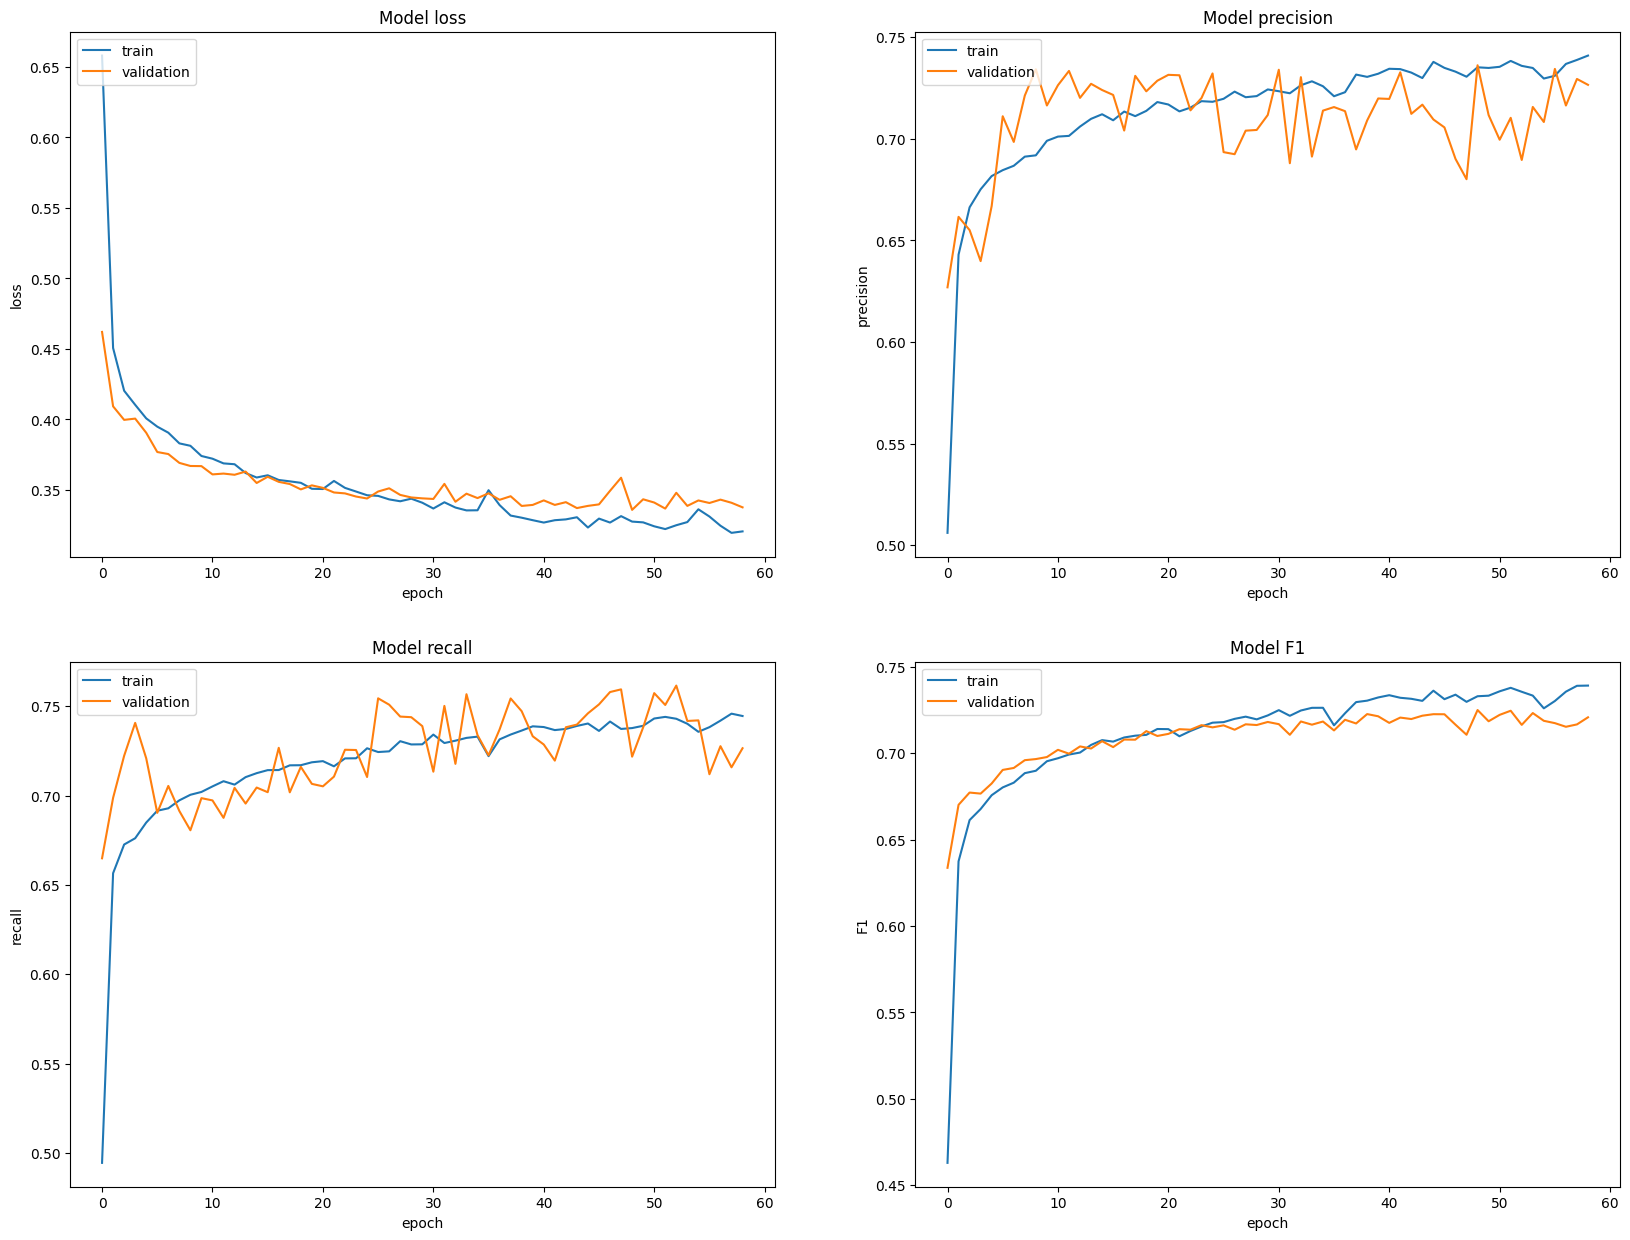

In [38]:

# Plot training history
fig, ((ax11, ax12), (ax13, ax14)) = plt.subplots(2, 2, figsize=(20, 15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.set_title('Model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Model F1')
ax14.set_ylabel('F1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')
plt.show()


## Prediction Example

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


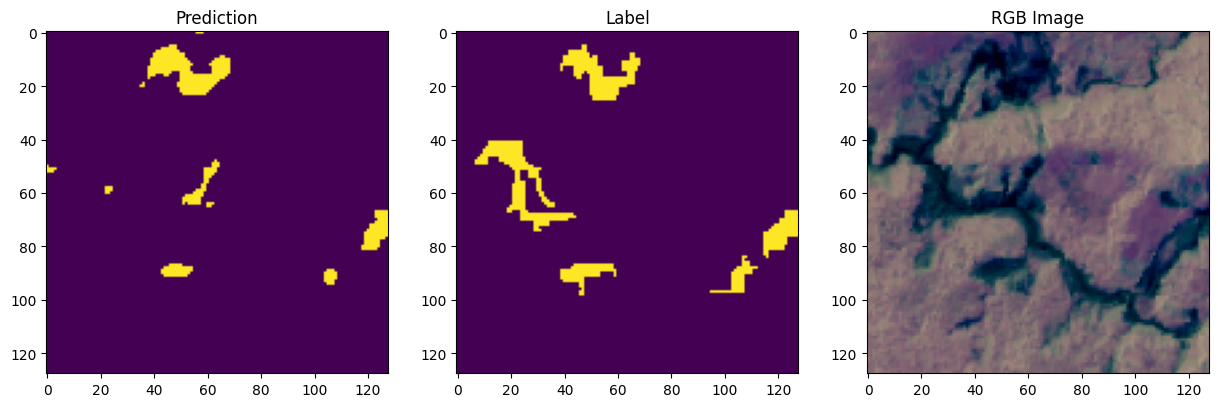

In [49]:
threshold = 0.5
pred_img = model.predict(x_valid)  # shape: (num_samples, 128, 128, 1)
pred_img = (pred_img > threshold).astype(np.uint8)

img_idx = 30
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
ax1.imshow(pred_img[img_idx, :, :, 0])
ax1.set_title("Prediction")
ax2.imshow(y_valid[img_idx, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img_idx, :, :, 0:3])
ax3.set_title("RGB Image")
plt.show()


## Validating on New Data

Dataset loading completed:
Total image files provided: 245
Valid images loaded: 245
Corrupted/failed image files: 0
Validation images shape: (245, 128, 128, 6)
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step


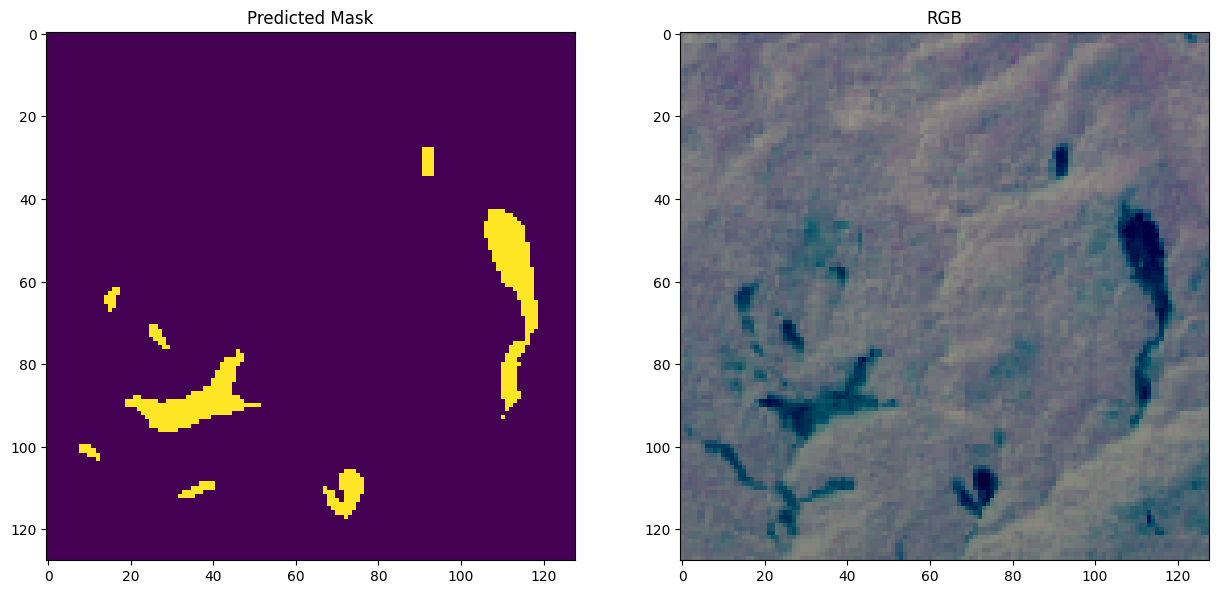

In [50]:
validation_url = "/content/gdrive/MyDrive/Colab Notebooks/data/ValidateData/*.h5"
img_val_paths = sorted(glob.glob(validation_url))

VAL_XX, _ = load_dataset(img_val_paths, mask_paths=None)
print("Validation images shape:", VAL_XX.shape)

val_preds = model.predict(VAL_XX)
val_preds = (val_preds > threshold).astype(np.uint8)

img_val_idx = 1
fig, (axv1, axv2) = plt.subplots(1, 2, figsize=(15, 10))
axv1.imshow(val_preds[img_val_idx, :, :, 0])
axv1.set_title("Predicted Mask")
axv2.imshow(VAL_XX[img_val_idx, :, :, 0:3])
axv2.set_title("RGB")
plt.show()

# Optionally save predicted masks
write_directory = "data/validation/mask"
os.makedirs(write_directory, exist_ok=True)
for i, img_path in enumerate(img_val_paths):
    name = os.path.basename(img_path).replace("image", "mask")
    with h5py.File(os.path.join(write_directory, name), 'w') as h5f:
        pred_mask = val_preds[i, :, :, 0]
        h5f.create_dataset('mask', data=pred_mask)


## Interpretability: Saliency Map & Grad-CAM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K, layers, Model

# 1) SmoothGrad Saliency
def smoothgrad_saliency(model, x, nsamples=25, noise_level=0.1):
    x = x[None].astype(np.float32)
    stdev = noise_level * x.std()
    total_grad = np.zeros(x.shape[1:3], dtype=np.float32)
    for _ in range(nsamples):
        noise = np.random.normal(0, stdev, x.shape).astype(np.float32)
        x_noisy = x + noise
        with tf.GradientTape() as tape:
            tape.watch(x_noisy)
            pred = model(x_noisy)[0,...,0]
            score = tf.reduce_sum(pred)
        grads = tape.gradient(score, x_noisy)[0]
        sal = np.max(np.abs(grads), axis=-1)
        total_grad += sal
    smooth = total_grad / nsamples
    return (smooth - smooth.min()) / (smooth.max() - smooth.min() + 1e-8)

# 2) Grad‑CAM
def gradcam(model, x, layer_name=None):
    x_tf = x[None].astype(np.float32)
    if layer_name is None:
        layer_name = [l.name for l in model.layers if 'conv2d' in l.name][-1]
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        fmap, pred = grad_model(x_tf)
        loss = tf.reduce_sum(pred)
    grads = tape.gradient(loss, fmap)
    weights = tf.reduce_mean(grads, axis=(0,1,2))
    cam = tf.reduce_sum(fmap[0] * weights, axis=-1)
    cam = tf.maximum(cam, 0)
    cam = cam / (cam.numpy().max() + 1e-8)
    cam = cv2.resize(cam.numpy(), x.shape[1:3][::-1])
    return cam

# 3) Integrated Gradients
def integrated_gradients(model, x, baseline=None, steps=50):
    x = x[None].astype(np.float32)
    if baseline is None:
        baseline = np.zeros_like(x)
    alphas = np.linspace(0,1,steps)[:,None,None,None,None]
    total_grad = np.zeros_like(x)
    for a in alphas:
        with tf.GradientTape() as tape:
            inp = baseline + a*(x - baseline)
            tape.watch(inp)
            pred = model(inp)[0,...,0]
            loss = tf.reduce_sum(pred)
        grads = tape.gradient(loss, inp)[0]
        total_grad += grads
    avg_grad = total_grad / steps
    ig = (x[0] - baseline[0]) * avg_grad
    ig = np.max(np.abs(ig), axis=-1)
    return (ig - ig.min()) / (ig.max() - ig.min() + 1e-8)

# 4) Overlay utility
def overlay_heatmap(img_rgb, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    hm = np.uint8(255 * heatmap)
    hm_color = cv2.applyColorMap(hm, colormap)
    hm_color = cv2.cvtColor(hm_color, cv2.COLOR_BGR2RGB) / 255.0
    return (1-alpha)*img_rgb + alpha*hm_color

# 5) Top‑level visualizer
def visualize_interpretability(model, x, methods=['smoothgrad','gradcam','intgrad']):
    # Ensure x is a NumPy array
    if isinstance(x, tf.Tensor):
        x = x.numpy()
    H, W, C = x.shape

    # Build an RGB composite from channels 0–2
    img_rgb = x[..., :3]
    img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min() + 1e-8)

    # Compute each requested map
    maps = {}
    if 'smoothgrad' in methods:
        maps['SmoothGrad'] = smoothgrad_saliency(model, x)
    if 'gradcam' in methods:
        maps['Grad‑CAM']   = gradcam(model, x)
    if 'intgrad' in methods:
        maps['Integrated Gradients'] = integrated_gradients(model, x)

    # Plot input + maps + overlays
    n = len(maps)
    fig, axes = plt.subplots(2, n+1, figsize=(4*(n+1), 8))
    axes[0,0].imshow(img_rgb); axes[0,0].set_title("Input RGB"); axes[0,0].axis('off')
    axes[1,0].axis('off')

    for i, (name, heat) in enumerate(maps.items(), start=1):
        # Raw heatmap
        ax = axes[0,i]
        im = ax.imshow(heat, cmap='viridis')
        ax.set_title(f"{name} Map"); ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        # Overlayed on RGB
        ax2 = axes[1,i]
        over = overlay_heatmap(img_rgb, heat, alpha=0.4)
        ax2.imshow(over)
        ax2.set_title(f"{name} Overlay"); ax2.axis('off')

    plt.tight_layout()
    plt.show()


In [5]:
%matplotlib inline

# 1) Select which tf.data.Dataset you want to probe
#    It must already exist in your session from your data‐loading cells.
# fallback logic
if 'valid_ds' in globals():
    dataset = valid_ds
elif 'test_ds' in globals():
    dataset = test_ds
else:
    dataset = train_ds
dataset = valid_ds  # or test_ds, or even train_ds
# fallback logic
if 'valid_ds' in globals():
    dataset = valid_ds
elif 'test_ds' in globals():
    dataset = test_ds
else:
    dataset = train_ds

x_batch, y_batch = next(iter(dataset))
visualize_interpretability(model, x_batch[0], methods=['smoothgrad','gradcam','intgrad'])


# 2) Grab one batch & pick the first example
x_batch, y_batch = next(iter(dataset))
x_example = x_batch[0]  # shape (128,128,6)

# 3) Visualize
visualize_interpretability(
    model,
    x_example,
    methods=['smoothgrad','gradcam','intgrad']
)


NameError: name 'train_ds' is not defined

# Sensitivity Analysis


In [54]:
def channel_sensitivity(model, x, channel_idx, baseline='zero'):
    original_pred = model.predict(x)[0, :, :, 0]

    x_mod = x.copy()
    if baseline == 'zero':
        x_mod[0, :, :, channel_idx] = 0.0
    else:
        # set channel to mean value
        mean_val = np.mean(x_mod[0, :, :, channel_idx])
        x_mod[0, :, :, channel_idx] = mean_val

    new_pred = model.predict(x_mod)[0, :, :, 0]
    diff = np.abs(original_pred - new_pred)
    mean_diff = diff.mean()
    return mean_diff

# Example usage: measure each channel’s importance
test_img = x_valid[None, 0, ...]  # pick one image
num_channels = test_img.shape[-1]
for c in range(num_channels):
    sensitivity = channel_sensitivity(model, test_img, c, baseline='zero')
    print(f"Channel {c} sensitivity (zero baseline):", sensitivity)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Channel 0 sensitivity (zero baseline): 0.34431347
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Channel 1 sensitivity (zero baseline): 4.356396e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Channel 2 sensitivity (zero baseline): 4.9407096e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Channel 3 sensitivity (zero baseline): 7.0017486e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Channel 4 sensitivity (zero baseline): 5.080424e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Channel 5 sensitivity (zero baseline): 6.2827196e-05


## Implementing LIME

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5c39ee8de615808a426072474cbb950a4acb9f1d79e99ac12b0de35192d436b6
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━

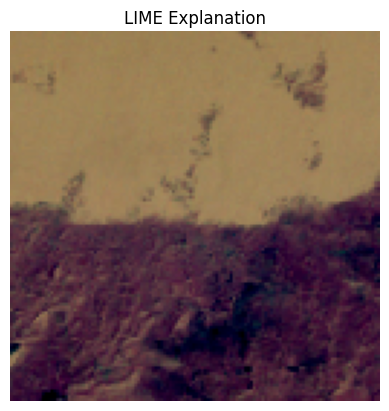

In [55]:
!pip install lime
from lime import lime_image
from skimage.segmentation import slic


def explain_with_lime(model, image, num_samples=1000):
    explainer = lime_image.LimeImageExplainer()

    # Function to predict using the U-Net model; note that LIME expects a 3D image input
    def model_predict(images):
        images = np.array(images)
        # Assuming images are 128x128 with 6 channels
        preds = model.predict(images)
        # Return predictions in a suitable format; for segmentation, you might flatten the output or summarize per region.
        return preds.reshape((images.shape[0], -1))

    explanation = explainer.explain_instance(
        image.astype('double'),
        model_predict,
        top_labels=1,
        hide_color=0,
        num_samples=num_samples,
        segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10)
    )
    return explanation

# Select a representative validation image (e.g., the same test_img used for saliency/Grad-CAM)
lime_explanation = explain_with_lime(model, x_valid[0])

# Visualize the explanation (this depends on how you want to overlay the superpixel weights)
temp, mask = lime_explanation.get_image_and_mask(
    label=lime_explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

plt.imshow(temp[..., :3])
plt.title("LIME Explanation")
plt.axis('off')
plt.show()
